An initial notebook.

In [1]:
import wrangle as w 
import os 
from env import get_db_url

import pandas as pd 
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import mitosheet
import folium
from folium.plugins import FastMarkerCluster

In [2]:
def acquire_zillow_data(use_cache=True):
    '''
    This function returns a snippet of zillow's database as a Pandas DataFrame. 
    When this SQL data is cached and extant in the os directory path, return the data as read into a df. 
    If csv is unavailable, aquisition proceeds regardless,
    reading the queried database elements into a dataframe, creating a cached csv file
    and lastly returning the dataframe for some sweet data science perusal.
    '''

    # If the cached parameter is True, read the csv file on disk in the same folder as this file 
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached CSV')
        return pd.read_csv('zillow.csv', dtype={'buildingclassdesc': 'str', 'propertyzoningdesc': 'str'})

    # When there's no cached csv, read the following query from Codeup's SQL database.
    print('CSV not detected.')
    print('Acquiring data from SQL database instead.')
    df = pd.read_sql(
        '''
 SELECT
    prop.*,
    predictions_2017.logerror,
    predictions_2017.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
    FROM predictions_2017
    GROUP BY parcelid
) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                      AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
LEFT JOIN storytype story USING (storytypeid)
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL
  AND prop.longitude IS NOT NULL
  AND transactiondate <= '2017-12-31';             
        '''
                    , get_db_url('zillow'))
    
    df.propertyzoningdesc.astype(str)
    
    
    print('Acquisition Complete. Dataframe available and is now cached for future use.')
    # create a csv of the dataframe for the sake of efficiency. 
    df.to_csv('zillow.csv', index=False)
    
    return df

In [3]:
df = acquire_zillow_data()

Using cached CSV


In [4]:
def remove_columns(df, cols_to_remove):
    '''
    This function takes in a pandas dataframe and a list of columns to remove. It drops those columns from the original df and returns the df.
    '''
    df = df.drop(columns=cols_to_remove)
    return df
                 
                 
def handle_missing_values(df, prop_required_column=0.5 , prop_required_row=0.5):
    '''
    This function takes in a pandas dataframe, default proportion of required columns (set to 50%) and proprtion of required rows (set to 75%).
    It drops any rows or columns that contain null values more than the threshold specified from the original dataframe and returns that dataframe.
    
    Prior to returning that data, it will print statistics and list counts/names of removed columns/row counts 
    '''
    original_cols = df.columns.to_list()
    original_rows = df.shape[0]
    threshold = int(round(prop_required_column * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    remaining_cols = df.columns.to_list()
    remaining_rows = df.shape[0]
    dropped_col_count = len(original_cols) - len(remaining_cols)
    dropped_cols = list((Counter(original_cols) - Counter(remaining_cols)).elements())
    print(f'The following {dropped_col_count} columns were dropped because they were missing more than {prop_required_column * 100}% of data: \n{dropped_cols}\n')
    dropped_rows = original_rows - remaining_rows
    print(f'{dropped_rows} rows were dropped because they were missing more than {prop_required_row * 100}% of data')
    return df

# combined in one function
def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.5):
    '''
    This function calls the remove_columns and handle_missing_values to drop columns that need to be removed. It also drops rows and columns that have more 
    missing values than the specified threshold.
    '''
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [5]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:
        # get quartiles
        q1, q3 = df[f'{col}'].quantile([.25, .75])  
        # calculate interquartile range
        iqr = q3 - q1   
        # get upper bound
        upper_bound = q3 + k * iqr 
        # get lower bound
        lower_bound = q1 - k * iqr   

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [6]:
def moveDecimalPoint(series, decimal_places):
    '''
    Move the decimal place in a given number.

    args:
        num (int)(float) = The number in which you are modifying.
        decimal_places (int) = The number of decimal places to move.
    
    returns:
        (float)
    
    ex. moveDecimalPoint(11.05, -2) returns: 0.1105
    '''
    for _ in range(abs(decimal_places)):

        if decimal_places>0:
            series *= 10; #shifts decimal place right for each row
        else:
            series /= 10.; #shifts decimal place left for each row 

    return series

In [7]:
df.shape
# first I will prep it without removing outliers. 

(77380, 68)

In [8]:
def prep_zillow(df):
    
    df = data_prep(df)
    
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
      (df.propertylandusedesc == 'Mobile Home') |
      (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
      (df.propertylandusedesc == 'Cluster Home')]
    
    # Remove properties that couldn't even plausibly be a studio. 
    df= df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0)]
    
    # Remove properties where there is not a single bathroom.
    df = df[df.bathroomcnt > 0]
    
 # keep only properties with square footage greater than 70 (legal size of a bedroom)
    df = df[df.calculatedfinishedsquarefeet > 70]
    
    # Minimum lot size of single family units.
    df = df[df.lotsizesquarefeet >= 5000].copy()

    # Clear indicators of single unit family. Other codes non-existent or indicate commercial sites. 
   # 0100 - Single Residence
   # 0101 Single residence with pool
   # 0104 - Single resident with therapy pool 
    df = df[(df.propertycountylandusecode == '0100') |
            (df.propertycountylandusecode == '0101') |
            (df.propertycountylandusecode == '0104') |
            (df.propertycountylandusecode == '122') | 
            (df.propertycountylandusecode == '1111') |
            (df.propertycountylandusecode == '1110') |
            (df.propertycountylandusecode == '1')
           ]
    
    
    # Remove 13 rows where unit count is 2. The NaN's can be safely assumed as 1 and were just mislabeled in other counties.  
    df = df[df['unitcnt'] != 2]
    df['unitcnt'].fillna(1)
    
    
    # Property where finished area is 152 but bed count is 5. 
    df = df.drop(labels=75325, axis=0)
    
      
            
    # Redudant columns or uninterpretable columns:
    # Unit count was dropped because now its known that theyre all 1. 
    # Finished square feet is equal to calculated sq feet. 
    # full bathcnt and calculatedbathnbr are equal to bathroomcnt
    # property zoning desc is unreadable. 
    # assessment year is unnecessary, all values are 2016. 
    # property land use desc is always single family residence now.
    # same with property landuse type id. 
    # room count must be for a different category, as it is always 0.
    # regionidcounty reveals the same information as FIPS.  
    # Id does nothing, and parcelid is easier to represent. 

    
    df =df.drop(columns= ['finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
                      'propertyzoningdesc', 'unitcnt', 'propertylandusedesc',
                      'assessmentyear', 'roomcnt', 'regionidcounty', 'propertylandusetypeid',
                      'heatingorsystemtypeid', 'id', 'heatingorsystemdesc', 'buildingqualitytypeid',
                         'rawcensustractandblock'],
            axis=1)
    
    
    # The last nulls can be dropped altogether. 
    df = df.dropna()
    
    # Because of the significant impact outliers will have on clustering, I am using 1.5 as my k
    # for one, it's the standard value for removing based on IQR; second, data integrity is already
    # clear enough, so I won't lose sleep over these losses. Ironic that I state that while sleep-deprived.
    #df = remove_outliers(df, 1.5, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
    #                            'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'censustractandblock'])
    
    # the city code is supposed to have five digits. Converted to integer to do an accurate length count as a subsequent string. 
    df.regionidcity = df.regionidcity.astype(int)
    df = df[df.regionidcity.astype(str).apply(len) == 5]
        # the same applies to the zip code.   
    df.regionidzip = df.regionidzip.astype(int)
    df = df[df.regionidzip.astype(str).apply(len) == 5]

    df['yearbuilt'] = df['yearbuilt'].astype(int)
    df.yearbuilt = df.yearbuilt.astype(object) 
    df['age'] = 2017-df['yearbuilt']
    df = df.drop(columns='yearbuilt')
    df['age'] = df['age'].astype('int')
    print('Yearbuilt converted to age. \n')
                          
    df['county'] = df.fips.apply(lambda fips: '0' + str(int(fips)))
    df['county'].replace({'06037': 'los_angeles', '06059': 'orange', '06111': 'ventura'}, inplace=True)
    
    # Feature Engineering
     # create taxrate variable
    df['taxrate'] = round(df.taxamount/df.taxvaluedollarcnt*100, 2)
    # dollar per square foot- structure
    df['structure_cost_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
    # dollar per square foot- land
    df['land_cost_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    # Removing problematic outlier groups. K is at 1.5 since K-Means clustering is very sensitive to outliers 
    #df = remove_outliers(df, 1.5, ['age', 'structure_cost_per_sqft', 'taxrate',
     #                           'land_cost_per_sqft'])
    
    # create quarters based on transaction date
    # first convert from string to datetime format
    df['transactiondate'] = pd.to_datetime(df['transactiondate'], infer_datetime_format=True, errors='coerce')
    # then use pandas feature dt.
    df['fiscal_quarter'] = df['transactiondate'].dt.quarter
    # drop transaction date, since it can't be represented in a histogram 
    # actual dates can be retrieved from parcelid for those interested
    df = df.drop(columns='transactiondate')
    
    # there are less than 1% of values in both these fields, and neither are likely to hold value. Plus, a 
    # one bedroom for a family is unthinkable. I was tempted to remove five, since there are so many 5 
    # bedroom one bath arrangements, but I can't be too picky. 
    df = df[~df['bedroomcnt'].isin([6, 1])]
    
 
    # lastly, even after removing outliers from those columns, a few tax rates under 
    # 1% are present. This is unacceptable, as the Maximum Levy (in other words the 
    # bare minimum, too) is 1%. Additional fees can be added, but there's no getting 
    # under 1%. thus, rows falling beneath this must go. 
    df = df[df.taxrate >= 1.0]
    
    # move decimal points so lat
    # and long are correct. 
    
    lats = df['latitude']
    longs = df['longitude']
    
    round(moveDecimalPoint(lats, -6), 6)
    round(moveDecimalPoint(longs, -6), 6)
    
    
    #finally set the index
    df = df.set_index('parcelid')
    
    return df

In [9]:
df = prep_zillow(df)

The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Yearbuilt converted to age. 



In [12]:
ogrows = 77380
rowskeepingoutliers = 37842

In [10]:
df.shape

(37482, 22)

/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_15243/565537748.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft', 'fiscal_quarter']
['propertycountylandusecode', 'county']


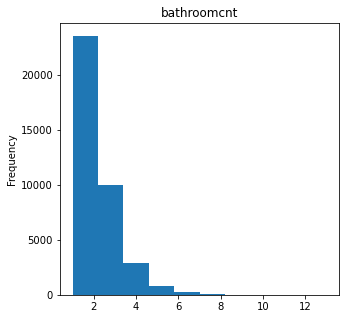

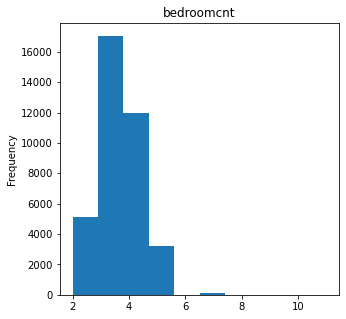

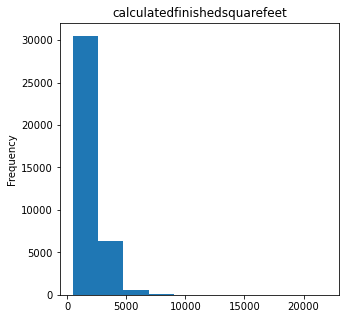

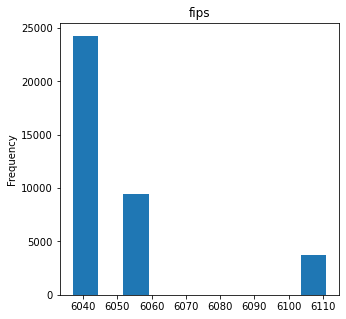

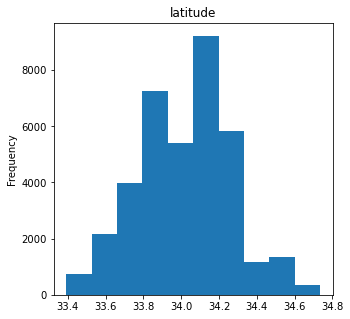

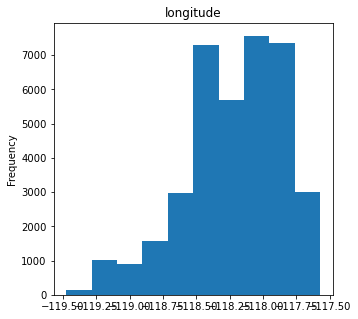

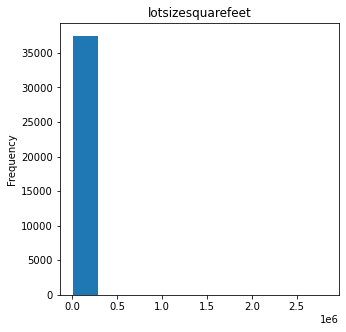

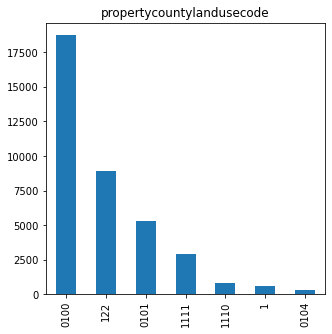

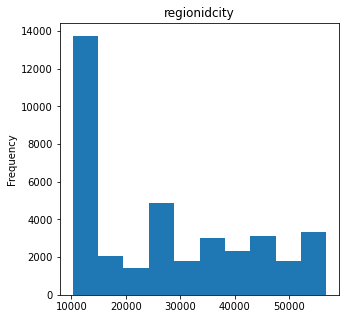

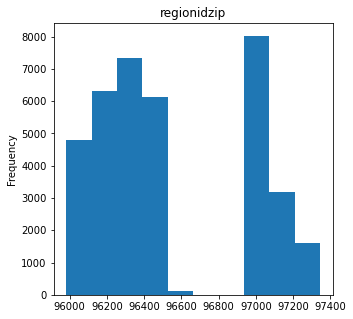

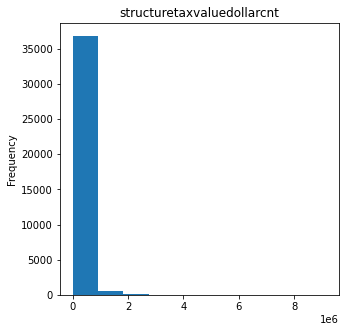

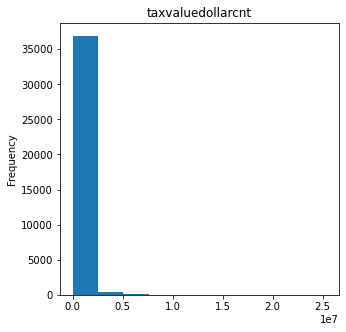

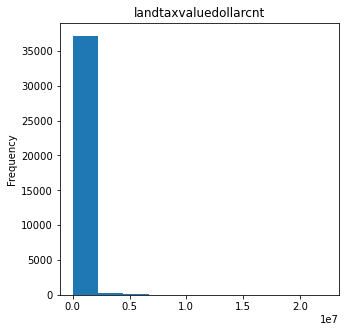

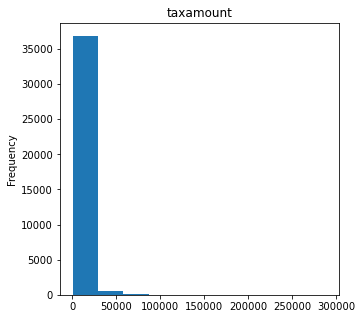

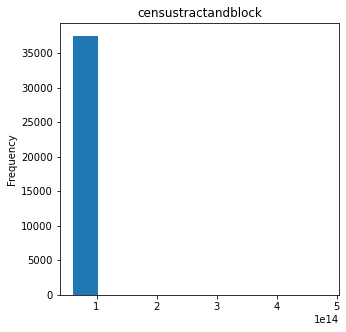

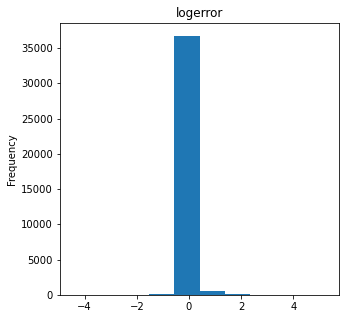

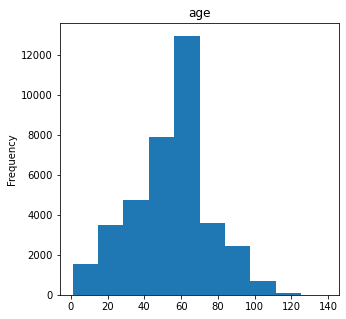

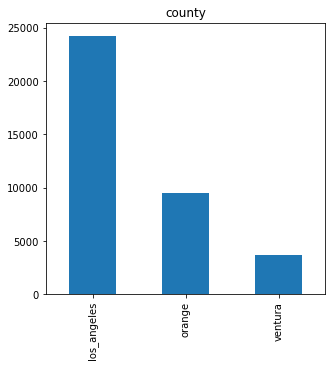

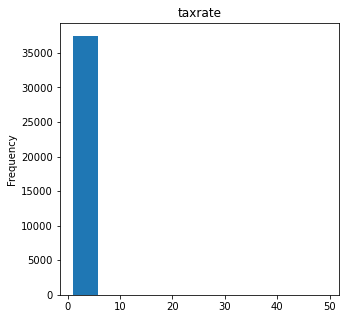

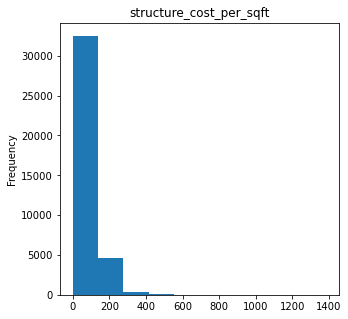

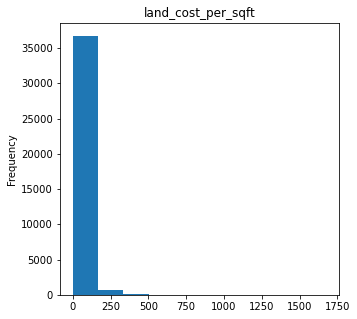

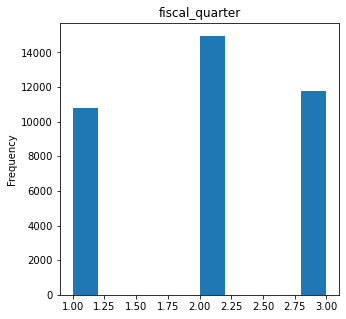

In [13]:
num_list = []
cat_list = []

# histograms when outliers are not removed
for column in df:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df[column]) :
        # show only the TOP 10 value count in each categorical data
        df[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

In [16]:
# Impossible to gather any insights across most columns in univariate analysis while outliers are present. 
df_3 = df.copy()

In [19]:
df_3 = df_3.drop(labels=12414696, axis=0)

In [20]:
df_3.shape

(37481, 22)

In [21]:
df_3 = remove_outliers(df_3, 3, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                                'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet', 'structure_cost_per_sqft',
                                'taxrate', 'land_cost_per_sqft'])

In [22]:
df_3.shape

(31595, 22)

In [23]:
df_1_5 = df.copy()

In [24]:
df_1_5 = remove_outliers(df_1_5, 1.5, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                                'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet', 'structure_cost_per_sqft',
                                'taxrate', 'land_cost_per_sqft'])

In [25]:
df_1_5.shape

(25316, 22)

In [ ]:
# a noticeable gap. Let's see how each effects visualization. 

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft', 'fiscal_quarter']
['propertycountylandusecode', 'county']


/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_15243/3633738602.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


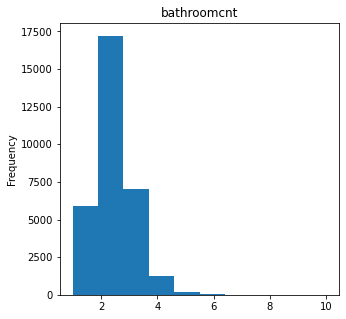

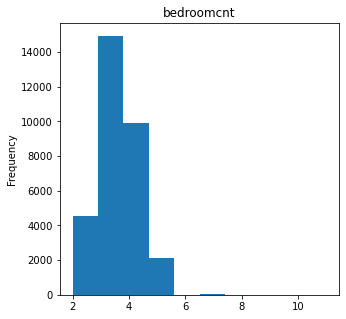

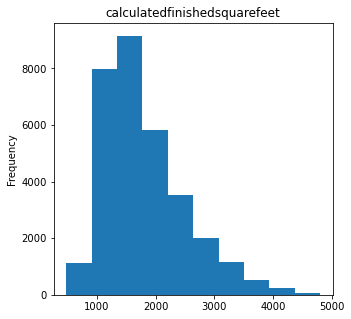

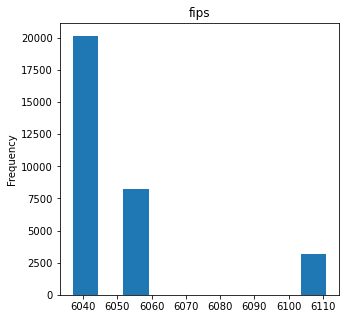

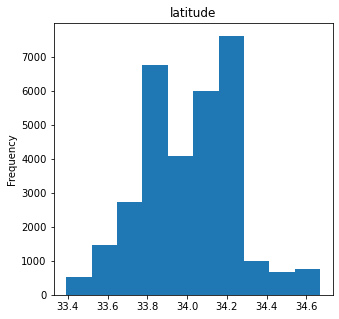

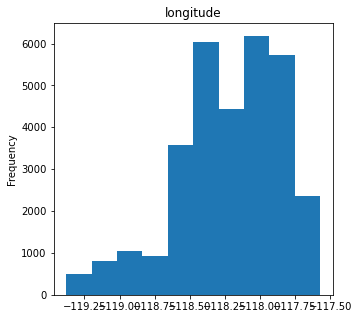

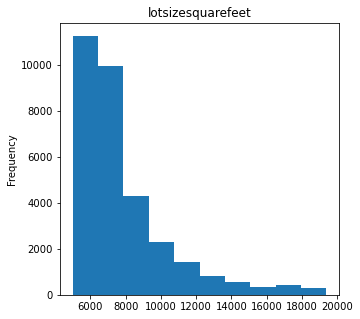

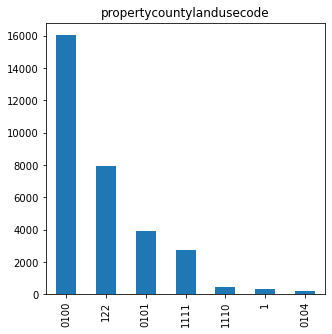

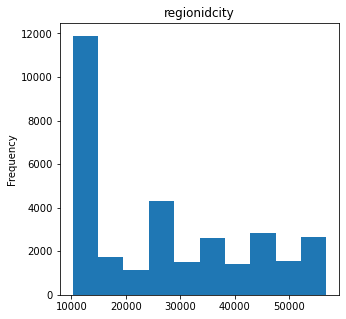

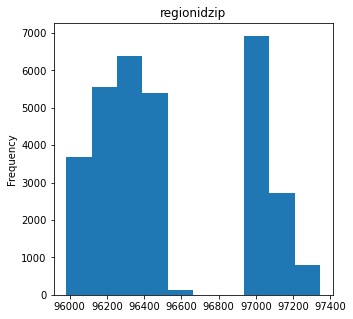

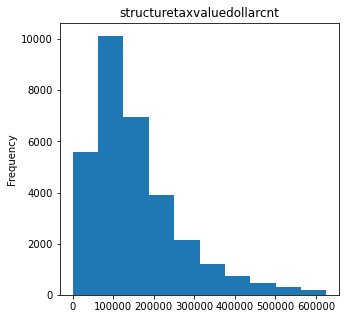

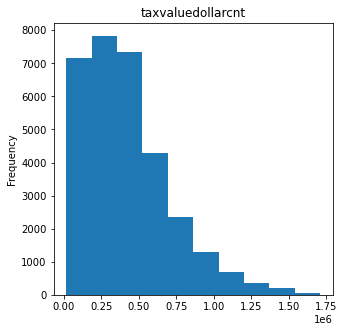

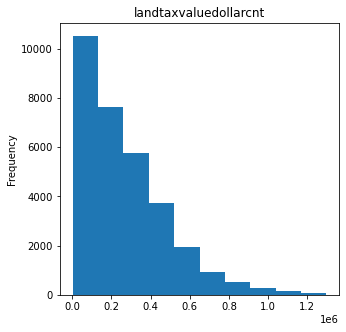

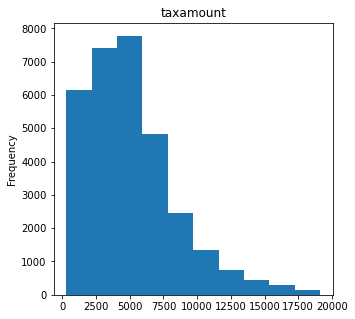

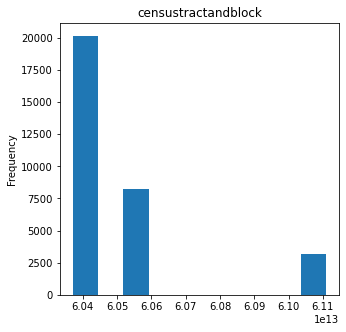

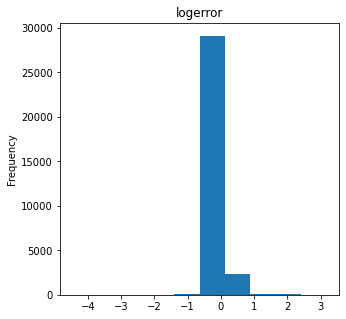

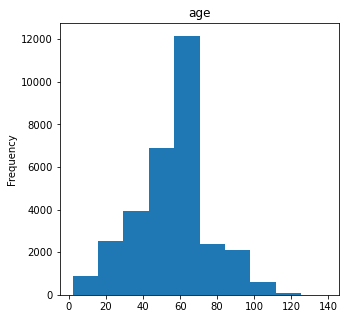

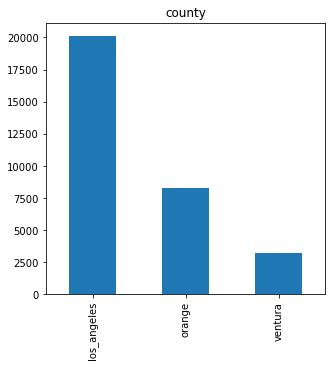

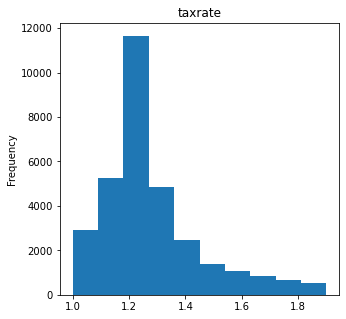

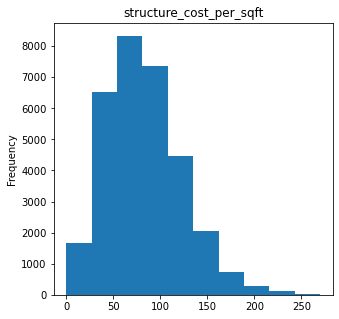

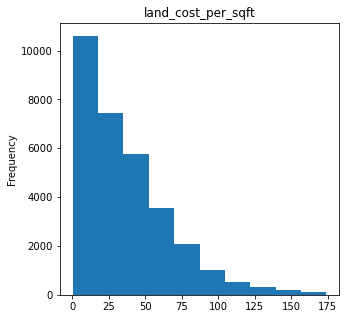

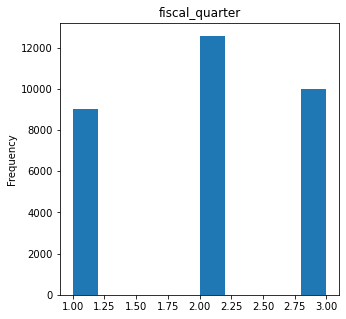

In [26]:
num_list = []
cat_list = []

# histograms when outliers are not removed
for column in df_3:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(df_3[column]):
        df_3[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df_3[column]) :
        # show only the TOP 10 value count in each categorical data
        df_3[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft', 'fiscal_quarter']
['propertycountylandusecode', 'county']


/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_15243/3583853827.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


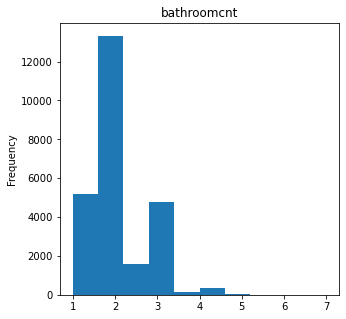

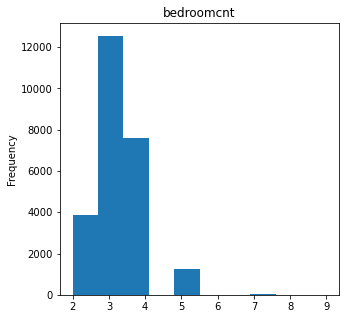

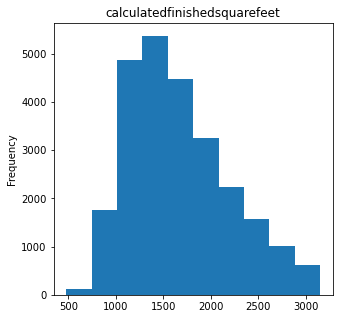

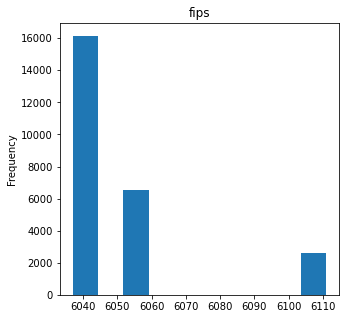

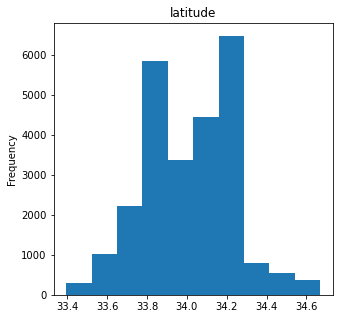

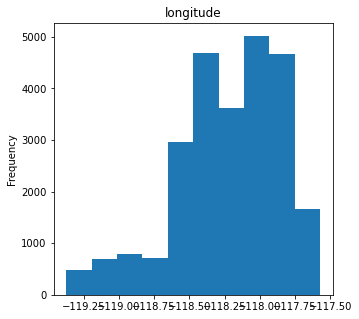

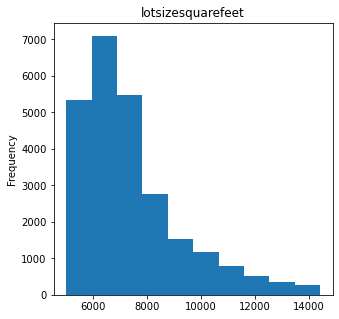

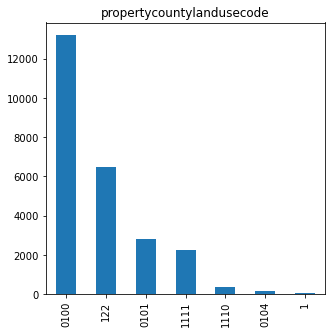

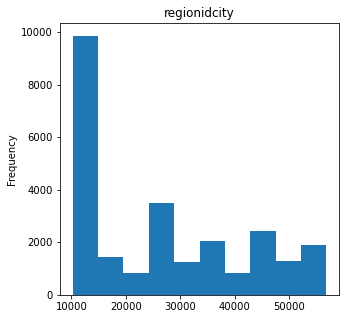

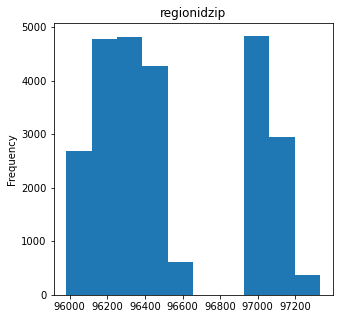

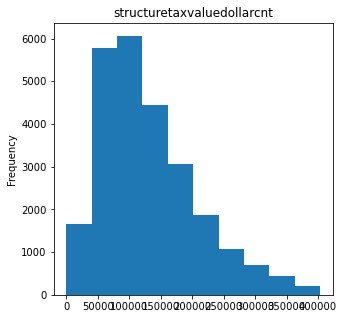

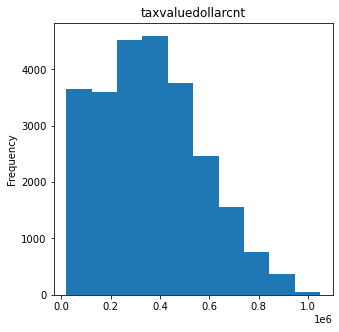

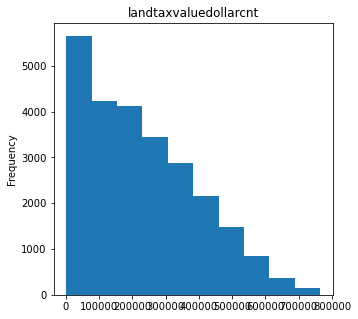

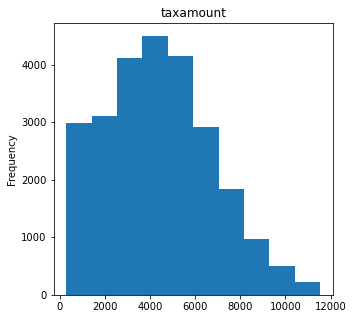

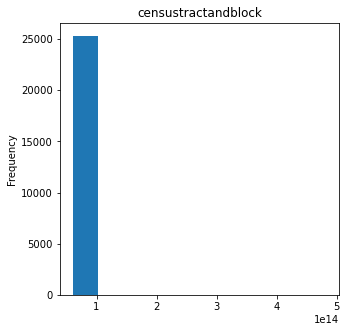

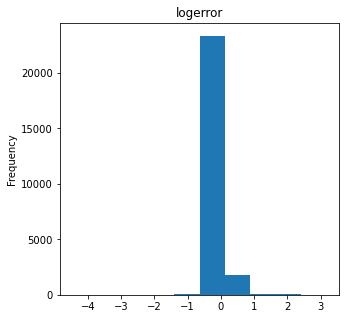

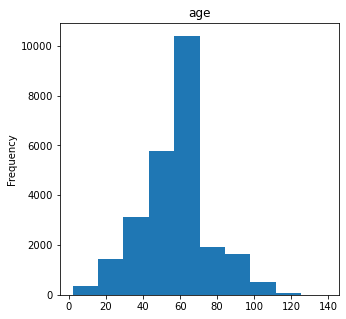

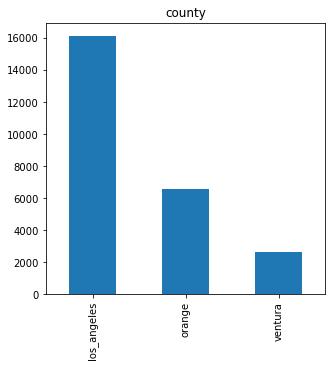

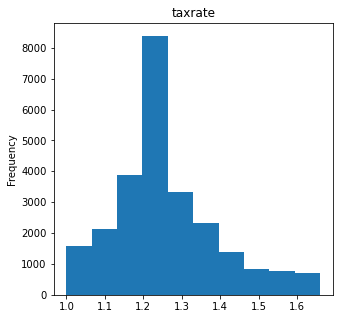

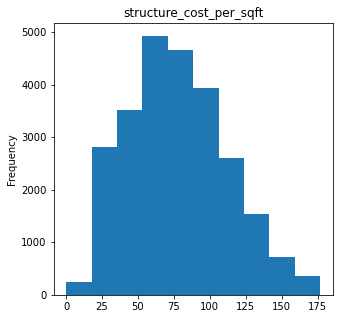

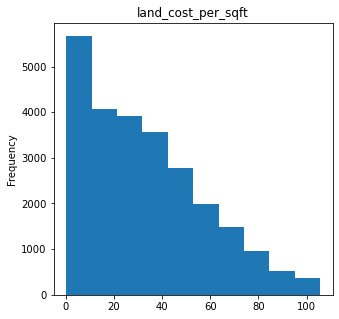

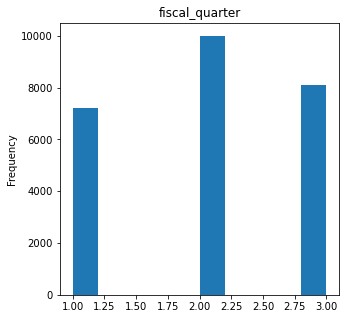

In [27]:
num_list = []
cat_list = []

# histograms when outliers are not removed
for column in df_1_5:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(df_1_5[column]):
        df_1_5[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df_1_5[column]) :
        # show only the TOP 10 value count in each categorical data
        df_1_5[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

Considering how visually, they're roughly equivalent, I can no longer see a reason to accept the extra data loss that comes with using 1.5 instead of 3 as the k for my outlier removal. 

In [ ]:
# I wonder if I can lose less by focusing on just orange and los angeles. 
# probably not an option for right now. But let's look anyway. 

In [28]:
lor = acquire_zillow_data()

Using cached CSV


In [29]:
def prep_zillow2(df):
    
    df = data_prep(df)
    
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
      (df.propertylandusedesc == 'Mobile Home') |
      (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
      (df.propertylandusedesc == 'Cluster Home')]
    
    # Remove properties that couldn't even plausibly be a studio. 
    df= df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0)]
    
    # Remove properties where there is not a single bathroom.
    df = df[df.bathroomcnt > 0]
    
 # keep only properties with square footage greater than 70 (legal size of a bedroom)
    df = df[df.calculatedfinishedsquarefeet > 70]
    
    # Minimum lot size of single family units.
    df = df[df.lotsizesquarefeet >= 5000].copy()

    # Clear indicators of single unit family. Other codes non-existent or indicate commercial sites. 
   # 0100 - Single Residence
   # 0101 Single residence with pool
   # 0104 - Single resident with therapy pool 
    df = df[(df.propertycountylandusecode == '0100') |
            (df.propertycountylandusecode == '0101') |
            (df.propertycountylandusecode == '0104') |
            (df.propertycountylandusecode == '122') | 
            (df.propertycountylandusecode == '1111') |
            (df.propertycountylandusecode == '1110') |
            (df.propertycountylandusecode == '1')
           ]
    
    
    # Remove 13 rows where unit count is 2. The NaN's can be safely assumed as 1 and were just mislabeled in other counties.  
    df = df[df['unitcnt'] != 2]
    df['unitcnt'].fillna(1)
    
    
    # Property where finished area is 152 but bed count is 5. 
    df = df.drop(labels=75325, axis=0)
    
      
            
    # Redudant columns or uninterpretable columns:
    # Unit count was dropped because now its known that theyre all 1. 
    # Finished square feet is equal to calculated sq feet. 
    # full bathcnt and calculatedbathnbr are equal to bathroomcnt
    # property zoning desc is unreadable. 
    # assessment year is unnecessary, all values are 2016. 
    # property land use desc is always single family residence now.
    # same with property landuse type id. 
    # room count must be for a different category, as it is always 0.
    # regionidcounty reveals the same information as FIPS.  
    # Id does nothing, and parcelid is easier to represent. 

    
    df =df.drop(columns= ['finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
                      'propertyzoningdesc', 'unitcnt', 'propertylandusedesc',
                      'assessmentyear', 'roomcnt', 'regionidcounty', 'propertylandusetypeid',
                      'heatingorsystemtypeid', 'id', 'heatingorsystemdesc', 'buildingqualitytypeid',
                         'rawcensustractandblock'],
            axis=1)
    
    
    # The last nulls can be dropped altogether. 
    df = df.dropna()
    

    # the city code is supposed to have five digits. Converted to integer to do an accurate length count as a subsequent string. 
    df.regionidcity = df.regionidcity.astype(int)
    df = df[df.regionidcity.astype(str).apply(len) == 5]
        # the same applies to the zip code.   
    df.regionidzip = df.regionidzip.astype(int)
    df = df[df.regionidzip.astype(str).apply(len) == 5]

    df['yearbuilt'] = df['yearbuilt'].astype(int)
    df.yearbuilt = df.yearbuilt.astype(object) 
    df['age'] = 2017-df['yearbuilt']
    df = df.drop(columns='yearbuilt')
    df['age'] = df['age'].astype('int')
    print('Yearbuilt converted to age. \n')
                          
    df['county'] = df.fips.apply(lambda fips: '0' + str(int(fips)))
    df['county'].replace({'06037': 'los_angeles', '06059': 'orange', '06111': 'ventura'}, inplace=True)
    df = df[df['fips'] != 6111]
    
    # Feature Engineering
     # create taxrate variable
    df['taxrate'] = round(df.taxamount/df.taxvaluedollarcnt*100, 2)
    # dollar per square foot- structure
    df['structure_cost_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
    # dollar per square foot- land
    df['land_cost_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    df = remove_outliers(df, 3, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                                'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet', 'structure_cost_per_sqft',
                                'taxrate', 'land_cost_per_sqft'])
    
    # create quarters based on transaction date
    # first convert from string to datetime format
    df['transactiondate'] = pd.to_datetime(df['transactiondate'], infer_datetime_format=True, errors='coerce')
    # then use pandas feature dt.
    df['fiscal_quarter'] = df['transactiondate'].dt.quarter
    # drop transaction date, since it can't be represented in a histogram 
    # actual dates can be retrieved from parcelid for those interested
    df = df.drop(columns='transactiondate')
    
    # lastly, even after removing outliers from those columns, a few tax rates under 
    # 1% are present. This is unacceptable, as the Maximum Levy (in other words the 
    # bare minimum, too) is 1%. Additional fees can be added, but there's no getting 
    # under 1%. thus, rows falling beneath this must go. 
    df = df[df.taxrate >= 1.0]
    
    # move decimal points so lat
    # and long are correct. 
    
    lats = df['latitude']
    longs = df['longitude']
    
    round(moveDecimalPoint(lats, -6), 6)
    round(moveDecimalPoint(longs, -6), 6)
    
    
    #finally set the index
    df = df.set_index('parcelid')
    
    # A row where the censustractandblock was out of range. Wasn't close to the raw, unlike the others, and started with 483 instead of 60, 61. Too large. 
    df = df.drop(labels=12414696, axis=0)
    
    return df

In [30]:
lor = prep_zillow2(lor)

The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Yearbuilt converted to age. 



In [32]:
lor.shape
# better than when using 1.5 for outliers in the full df
# 2000ish less rows than when 3 is used, despite three being used again. But 
# lets look at the histograms again. 

(28929, 22)

/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_15243/1584506858.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft', 'fiscal_quarter']
['propertycountylandusecode', 'county']


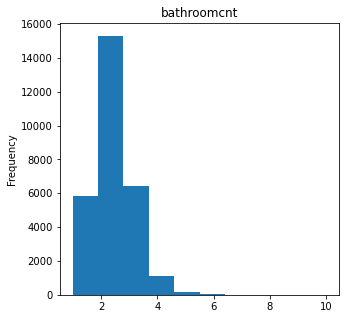

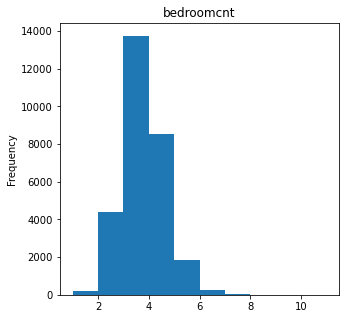

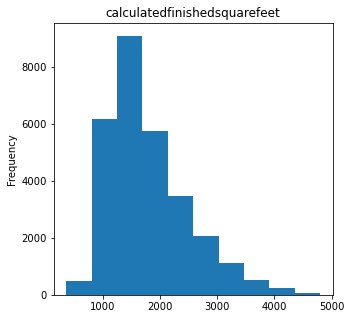

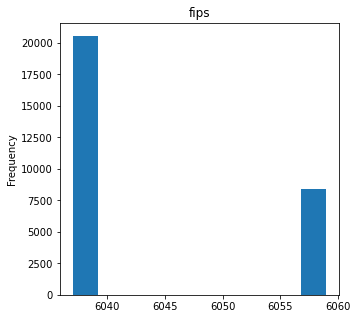

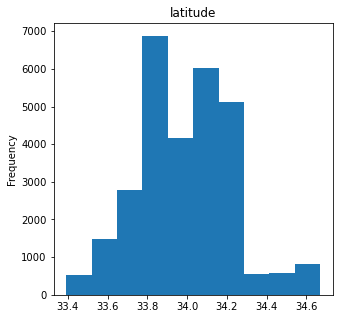

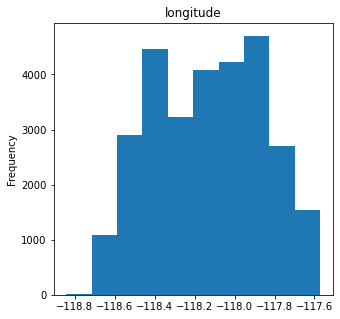

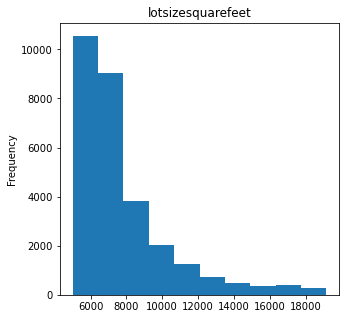

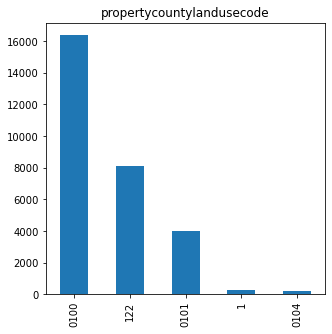

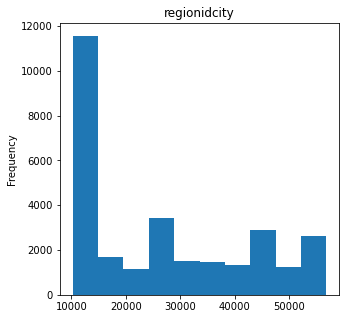

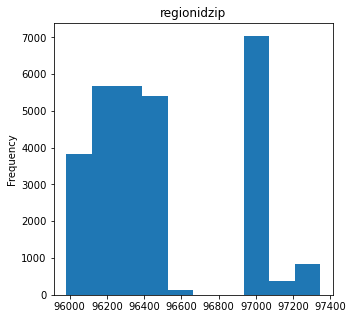

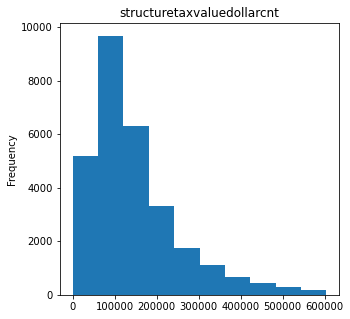

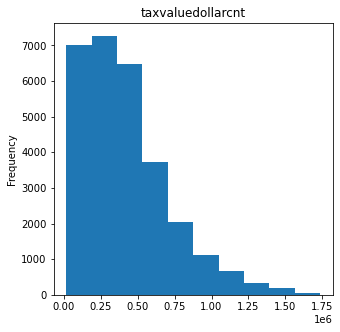

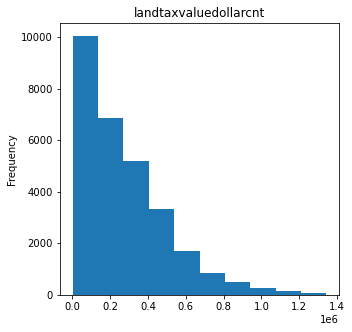

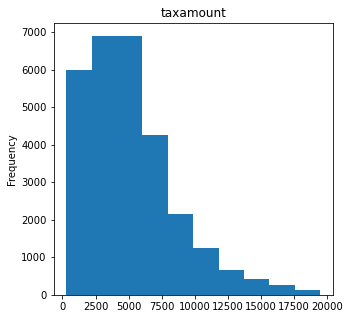

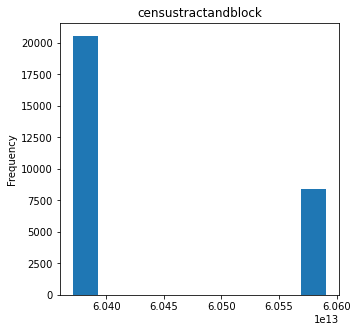

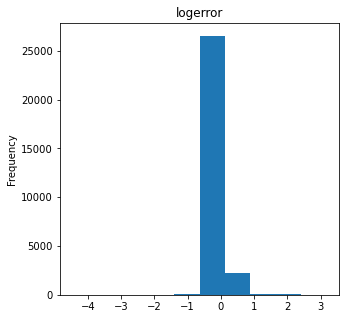

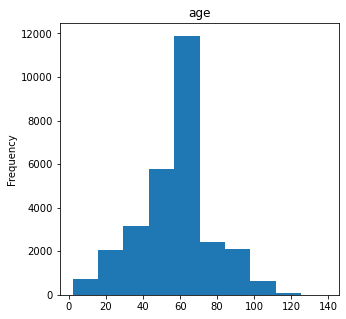

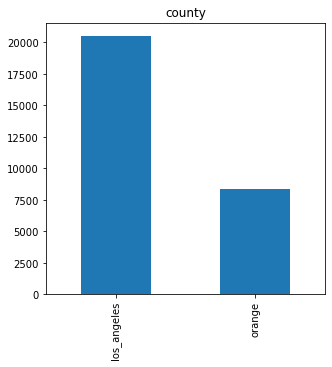

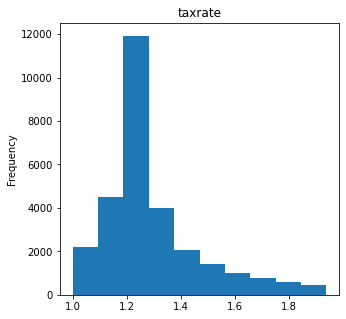

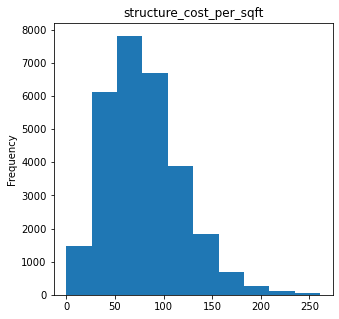

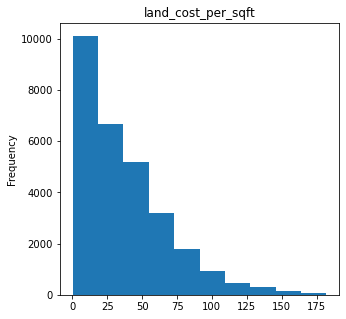

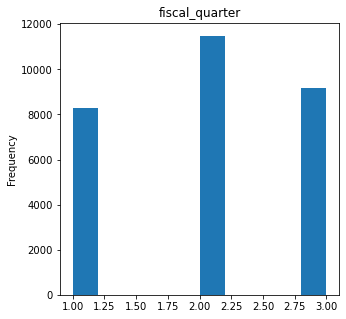

In [33]:
num_list = []
cat_list = []

for column in lor:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(lor[column]):
        lor[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(lor[column]) :
        # show only the TOP 10 value count in each categorical data
        lor[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

"the Los Angeles metropolitan area (also known as Metropolitan Los Angeles or Metro LA)[8] consisting of Los Angeles and Orange counties only. The Census Bureau designates the latter as the Los Angeles–Long Beach–Anaheim metropolitan statistical area, the fifth largest metropolitan area in the western hemisphere and the second-largest metropolitan area in the United States, by population"

I'm still tempted to just focus on orange and los angeles though. I just don't think I can do that here. I'd have a hard time justifying it
